# Test our method on the NLTT proper motion catalog

In [1]:
import os
import sys
sys.path.append('../src')
import P_binary
import P_random
import P_posterior
import const as c
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform, normal
from scipy.optimize import newton
from scipy import stats
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
import corner
from scipy.interpolate import interp1d, interp2d
from scipy.stats import gaussian_kde
import pickle


%matplotlib inline

/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# Read in sample from Tycho-2 table
filename = ('../data/rNLTT/catalog_tabs.dat')
t_full = Table.read(filename, format='ascii', guess=True)

# Change proper motion units from asec/yr to mas/yr
t_full['mu_ra'] = 1.0e3*t_full['mu_ra']
t_full['mu_dec'] = 1.0e3*t_full['mu_dec']
t_full['mu_ra_err'] = 1.0e3*t_full['mu_ra_err']
t_full['mu_dec_err'] = 1.0e3*t_full['mu_dec_err']

# Select only stars with proper motion uncertainties greater than 1 mas/yr - remove junk
ids_good = np.intersect1d(np.where(t_full['mu_ra_err'] >= 0.1), np.where(t_full['mu_dec_err'] >= 0.1))
# ids_good = np.union1d( np.where(t_full['mu_ra_err'] > 1.0)[0], \
#                       np.where(t_full['mu_dec_err'] > 1.0)[0] )
t = t_full[ids_good]

In [181]:
print t.colnames
print len(t)

['NLTT', 'ra', 'dec', 'mu_ra', 'mu_dec', 'mu_ra_err', 'mu_dec_err', 'V', 'B', 'R', 'J', 'H', 'K']
35882


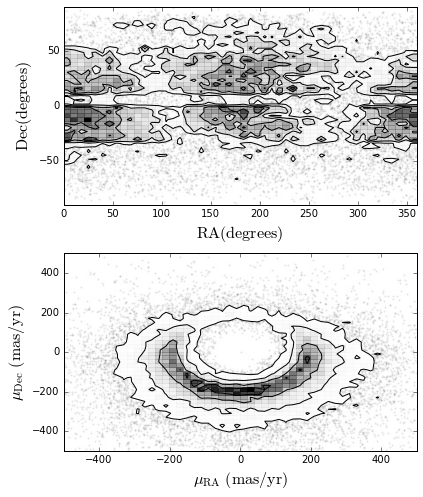

In [130]:
fig, ax = plt.subplots(2,1, figsize=(6,7))

contourf_kwargs = {'bins':50}
corner.hist2d(t['ra'], t['dec'], range=[(0,360),(-90,90)], ax=ax[0], **contourf_kwargs)
#plt.scatter(t['ra'], t['dec'], marker='.', alpha=0.1)
ax[0].set_xlim(0,360)
ax[0].set_ylim(-90,90)
ax[0].set_xlabel(r'${\rm RA (degrees)}$', size=16)
ax[0].set_ylabel(r'${\rm Dec (degrees)}$', size=16)

contourf_kwargs = {'bins':50}
corner.hist2d(t['mu_ra'], t['mu_dec'], range=[(-500,500),(-500,500)], ax=ax[1], **contourf_kwargs)
#corner.hist2d(t['mu_ra']*1.0e3*np.cos(t['dec']*np.pi/180.0), t['mu_dec']*1.0e3, range=[(-500,500),(-500,500)], ax=ax[1], **contourf_kwargs)
#plt.scatter(t['mu_ra'], t['mu_dec'], marker='.', alpha=0.1)
ax[1].set_xlabel(r'$\mu_{\rm RA}\ {\rm (mas/yr)}$', size=16)
ax[1].set_ylabel(r'$\mu_{\rm Dec}\ {\rm (mas/yr)}$', size=16)
ax[1].set_xlim(-500,500)
ax[1].set_ylim(-500,500)

#plt.axes().set_aspect('equal')
plt.tight_layout()
#plt.savefig('../figures/rNLTT_pos_mu.pdf')
plt.show()

In [4]:
# Read in pairs identified by Chaname & Gould

filename_CG = ('../data/rNLTT/Chaname_Gould_pairs.dat')
CG_pairs = Table.read(filename_CG, format='cds')
CG_pairs = CG_pairs[0:-1]  # Because the last line is blank
print CG_pairs.colnames

['NLTT-A', 'NLTT-B', 'RAdegA', 'DEdegA', 'RAdegB', 'DEdegB', 'pmRA-A', 'pmDE-A', 'pmRA-B', 'pmDE-B', 'VmagA', '(V-J)A', 'VmagB', '(V-J)B', 'SC-A', 'SC-B', 'CCode', 'Delpm', 'DelSep', 'PosAng', 'Bin', 'Allen']


In [133]:
pair_CG_accept = prob_out_CG[np.where(prob_out_CG['CCode'] < 4)]
pair_CG_reject = prob_out_CG[np.where(prob_out_CG['CCode'] > 3)]

print "There are", len(pair_CG_accept), "accepted binaries"
print "...and", len(pair_CG_reject), "rejected binaries."

There are 934 accepted binaries
...and 133 rejected binaries.


In [134]:
# Set zero probabilities to some arbitrarily small number
pair_CG_accept['P_random'][np.where(pair_CG_accept['P_random'] == 0.0)] = 1.0e-50
pair_CG_reject['P_random'][np.where(pair_CG_reject['P_random'] == 0.0)] = 1.0e-50
pair_CG_accept['P_binary'][np.where(pair_CG_accept['P_binary'] == 0.0)] = 1.0e-55
pair_CG_reject['P_binary'][np.where(pair_CG_reject['P_binary'] == 0.0)] = 1.0e-55


P_CG_accept = pair_CG_accept['P_binary'] / (pair_CG_accept['P_random'] + pair_CG_accept['P_binary'])
P_CG_reject = pair_CG_reject['P_binary'] / (pair_CG_reject['P_random'] + pair_CG_reject['P_binary'])
P_full = prob_out['P_binary'] / (prob_out['P_binary'] + prob_out['P_random'] + 1.0e-50)
P_full[np.where(np.isnan(P_full))] = 1.0e-50

### Load Chaname & Gould (2004) matches and our matches

In [3]:
prob_out = pickle.load( open("../data/rNLTT/prob_out.data", "rb"))
prob_out_CG = pickle.load( open("../data/rNLTT/prob_CG_100pc.data", "rb"))

print len(prob_out)
print len(prob_out_CG)

print prob_out.dtype
print prob_out_CG.dtype

1189
1067
[('i_1', '<i4'), ('i_2', '<i4'), ('ID_1', '<i4'), ('ID_2', '<i4'), ('P_random', '<f8'), ('P_binary', '<f8'), ('P_posterior', '<f8')]
[('NLTT_1', '<i4'), ('NLTT_2', '<i4'), ('P_random', '<f8'), ('P_binary', '<f8'), ('P_theta', '<f8'), ('P_mu', '<f8'), ('P_posterior', '<f8'), ('CCode', '<i4')]


/Library/Python/2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in log10
/Library/Python/2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in log10


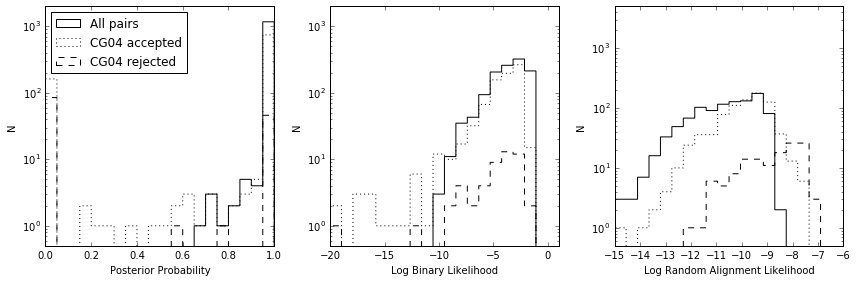

In [232]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

nbins = 20

# Full posterior
xmin, xmax = 0, 1
ax[0].hist(P_full, bins=nbins, histtype='step', color='k', range=[xmin, xmax], label='All pairs')
ax[0].hist(P_CG_accept, bins=nbins, histtype='step', color='k', linestyle='dotted', range=[xmin, xmax], label='CG04 accepted')
ax[0].hist(P_CG_reject, bins=nbins, histtype='step', color='k', linestyle='dashed', range=[xmin, xmax], label='CG04 rejected')

# ax[0].set_xscale('log')
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(0.5, 2000.0)
ax[0].set_yscale('log')
ax[0].set_xlabel('Posterior Probability')
ax[0].set_ylabel('N')

ax[0].legend(loc=2)


nbins = 20

# P_binary
xmin, xmax = -20, 1.0
ax[1].hist(np.log10(pair_CG_accept['P_binary']), bins=nbins, histtype='step', color='k', linestyle='dotted', range=[xmin, xmax])
ax[1].hist(np.log10(pair_CG_reject['P_binary']), bins=nbins, histtype='step', color='k', linestyle='dashed', range=[xmin, xmax])
ax[1].hist(np.log10(prob_out['P_binary'][np.where(prob_out['P_binary'] > 0.0)]), bins=nbins, histtype='step', color='k', range=[xmin, xmax])

ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(0.5, 2000.0)
ax[1].set_yscale('log')
ax[1].set_xlabel('Log Binary Likelihood')
ax[1].set_ylabel('N')



# P_random
xmin, xmax = -15, -6
ax[2].hist(np.log10(pair_CG_accept['P_random']), bins=nbins, histtype='step', color='k', linestyle='dotted', range=[xmin, xmax])
ax[2].hist(np.log10(pair_CG_reject['P_random']), bins=nbins, histtype='step', color='k', linestyle='dashed', range=[xmin, xmax])
ax[2].hist(np.log10(prob_out['P_random'][np.where(prob_out['P_random'] > 0.0)]), bins=nbins, histtype='step', color='k', range=[xmin, xmax])

ax[2].set_xlim(xmin, xmax)
ax[2].set_ylim(0.5, 5000.0)
ax[2].set_yscale('log')
ax[2].set_xlabel('Log Random Alignment Likelihood')
ax[2].set_ylabel('N')

plt.tight_layout()
plt.savefig('../figures/rNLTT_probs.pdf')
#plt.show()

In [19]:
P_binary.generate_binary_set()

Number of CG04 pairs with matches 883
Number of CG04 pairs with zero theta or delta mu matches 155
Number of CG04 pairs with non-zero matches 728
Number of CG04 pairs with non-zero matches, P>50% 475
Number of CG04 pairs with non-zero matches, P<50% 253
New binaries found, not in CG04: 551
New binaries found, not in CG04, non-zero theta, delta_mu: 132
Average delta mu error: 10.7216757867 mas/yr


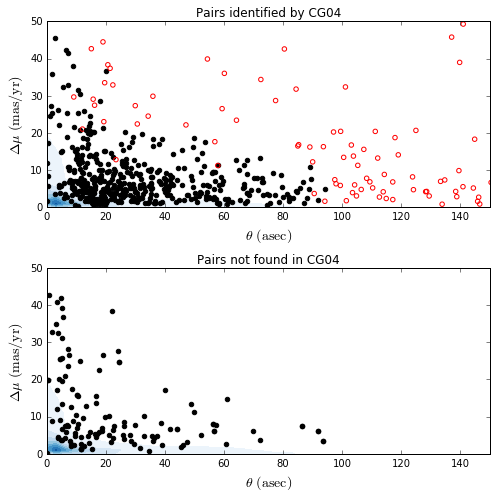

In [66]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,7))

#ax1 = fig.add_axes([0.0, 0.0, 0.8, 0.8])
#ax2 = fig.add_axes([0.0, 0.85, 0.8, 0.15])
#ax3 = fig.add_axes([0.85, 0.0, 0.15, 0.8])


nbins = 50
xmin, xmax = 0.0, 150.0
ymin, ymax = 0.0, 50.0


# Binary probability plot
theta_test = np.linspace(xmin, xmax, nbins)
delta_mu_test = np.linspace(ymin, ymax, nbins)
X, Y = np.meshgrid(theta_test, delta_mu_test)

Z = P_binary.get_P_binary(X.flatten(), Y.flatten())

levels = np.linspace(0.0001, 0.03, 10)
ax1.tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', levels=levels, extend='max')
ax2.tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', levels=levels, extend='max')

ax1.set_xlabel(r"$\theta\ ({\rm asec})$", fontsize=14)
ax2.set_xlabel(r"$\theta\ ({\rm asec})$", fontsize=14)
ax1.set_ylabel(r"$\Delta \mu\ ({\rm mas/yr})$", fontsize=14)
ax2.set_ylabel(r"$\Delta \mu\ ({\rm mas/yr})$", fontsize=14)


count_CG_all = 0
count_CG_nonzero = 0
count_CG_nonzero_good = 0
count_CG_nonzero_bad = 0
delta_mu_err = np.array([])
for i in np.arange(len(prob_out_CG)):

    id1 = np.where(prob_out_CG['NLTT_1'][i] == t['NLTT'])[0]
    id2 = np.where(prob_out_CG['NLTT_2'][i] == t['NLTT'])[0]

    if len(id1)==0 or len(id2)==0: continue
    
    ra1 = t['ra'][id1[0]]
    dec1 = t['dec'][id1[0]]
    ra2 = t['ra'][id2[0]]
    dec2 = t['dec'][id2[0]]
    
    mu_ra1 = t['mu_ra'][id1[0]]
    mu_dec1 = t['mu_dec'][id1[0]]
    mu_ra2 = t['mu_ra'][id2[0]]
    mu_dec2 = t['mu_dec'][id2[0]]

    mu_ra_err1 = t['mu_ra_err'][id1[0]]
    mu_dec_err1 = t['mu_dec_err'][id1[0]]
    mu_ra_err2 = t['mu_ra_err'][id2[0]]
    mu_dec_err2 = t['mu_dec_err'][id2[0]]

    delta_mu_err = np.append(delta_mu_err, np.sqrt(mu_ra_err1**2 + mu_dec_err1**2 + mu_ra_err2**2 + mu_ra_err2**2))

    prob_post = prob_out_CG['P_posterior'][i]
    
    theta = P_random.get_theta_proj_degree(ra1, dec1, ra2, dec2) * 3600.0
    delta_mu = P_random.get_delta_mu(mu_ra1, mu_dec1, mu_ra2, mu_dec2)
    
    
    count_CG_all = count_CG_all + 1
    if theta == 0.0 or delta_mu == 0.0: continue
    count_CG_nonzero = count_CG_nonzero + 1
    
#    print theta, delta_mu
    if prob_post > 0.5:
        ax1.scatter(theta, delta_mu, color='k')
        count_CG_nonzero_good = count_CG_nonzero_good + 1
    else:
        ax1.scatter(theta, delta_mu, facecolors='none', edgecolors='r')
        count_CG_nonzero_bad = count_CG_nonzero_bad + 1
    
print "Number of CG04 pairs with matches", count_CG_all
print "Number of CG04 pairs with zero theta or delta mu matches", count_CG_all-count_CG_nonzero
print "Number of CG04 pairs with non-zero matches", count_CG_nonzero
print "Number of CG04 pairs with non-zero matches, P>50%", count_CG_nonzero_good
print "Number of CG04 pairs with non-zero matches, P<50%", count_CG_nonzero_bad

match_non_CG = 0
match_non_CG_good = 0
# Now let's show pairs that we found, that Chaname & Gould (2004) missed
for i in np.arange(len(prob_out)):

    id1 = np.where(prob_out['ID_1'][i] == t['NLTT'])[0]
    id2 = np.where(prob_out['ID_2'][i] == t['NLTT'])[0]

    if len(id1)==0 or len(id2)==0: continue

    if np.any(prob_out['ID_1'][i] == prob_out_CG['NLTT_1']): continue
    if np.any(prob_out['ID_2'][i] == prob_out_CG['NLTT_2']): continue
        
        
    ra1 = t['ra'][id1[0]]
    dec1 = t['dec'][id1[0]]
    ra2 = t['ra'][id2[0]]
    dec2 = t['dec'][id2[0]]
    
    mu_ra1 = t['mu_ra'][id1[0]]
    mu_dec1 = t['mu_dec'][id1[0]]
    mu_ra2 = t['mu_ra'][id2[0]]
    mu_dec2 = t['mu_dec'][id2[0]]

    prob_post = prob_out['P_posterior'][i]
    
    match_non_CG = match_non_CG + 1
    
    theta = P_random.get_theta_proj_degree(ra1, dec1, ra2, dec2) * 3600.0
    delta_mu = P_random.get_delta_mu(mu_ra1, mu_dec1, mu_ra2, mu_dec2)
    if theta == 0.0 or delta_mu == 0.0: continue
    
    match_non_CG_good = match_non_CG_good + 1

    # print t['NLTT'][id1[0]], t['V'][id1[0]], t['B'][id1[0]], t['J'][id1[0]], t['V'][id2[0]], t['B'][id2[0]], t['J'][id2[0]]
    
#    print theta, delta_mu
    ax2.scatter(theta, delta_mu, color='k')

print "New binaries found, not in CG04:", match_non_CG
print "New binaries found, not in CG04, non-zero theta, delta_mu:", match_non_CG_good


ax1.set_title('Pairs identified by CG04')
ax2.set_title('Pairs not found in CG04')

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)



plt.tight_layout()
plt.savefig('../figures/rNLTT_CG04_pos_mu.pdf')
#plt.show()

print "Average delta mu error:", np.mean(delta_mu_err), "mas/yr"

In [59]:
print 184+155

339


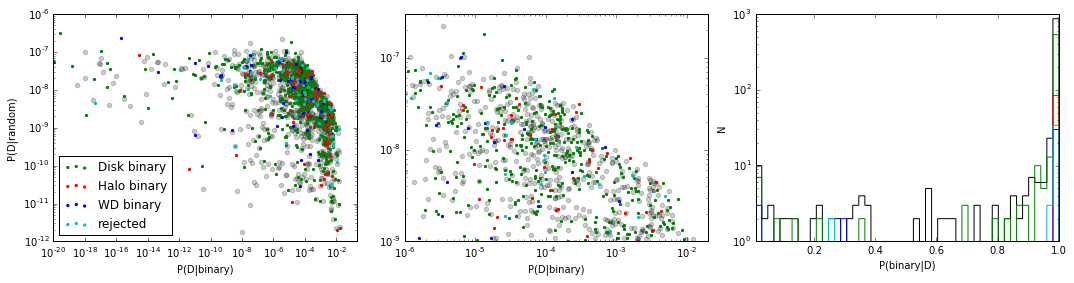

In [420]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))


# Plot entire NLTT catalog
ax[0].scatter(prob_out['P_binary'], prob_out['P_random'], color='k', alpha=0.2)
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 1)
ax[0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='g', label='Disk binary', s=5)
ids = np.where(prob_out_CG['CCode'] == 2)
ax[0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='r', label='Halo binary', s=5)
ids = np.where(prob_out_CG['CCode'] == 3)
ax[0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='b', label='WD binary', s=5)
ids = np.where(prob_out_CG['CCode'] > 3)
ax[0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='c', label='rejected', s=5)

ax[0].set_xlim(1.0e-20, 0.2)
ax[0].set_ylim(1.0e-12, 1.0e-6)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('P(D|binary)')
ax[0].set_ylabel('P(D|random)')
ax[0].legend(loc=3)



# Plot entire NLTT catalog
ax[1].scatter(prob_out['P_binary'], prob_out['P_random'], color='k', alpha=0.2)
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 1)
ax[1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='g', label='Disk binary', s=5)
ids = np.where(prob_out_CG['CCode'] == 2)
ax[1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='r', label='Halo binary', s=5)
ids = np.where(prob_out_CG['CCode'] == 3)
ax[1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='b', label='WD binary', s=5)
ids = np.where(prob_out_CG['CCode'] > 3)
ax[1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='c', label='Rejected', s=5)

ax[1].set_xlim(1.0e-6, 2.0e-2)
ax[1].set_ylim(1.0e-9, 3.0e-7)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('P(D|binary)')






xmin, xmax = 0.01, 1.0
bins=40
# Plot entire NLTT catalog
ax[2].hist(prob_out['P_posterior'], histtype='step', color='k', range=[xmin,xmax], bins=nbins)
# Plot Chaname & Gould (2004) pairs
ids = np.intersect1d(np.where(prob_out_CG['CCode'] == 1), np.where(prob_out_CG['P_posterior']>1.0e-10))
ax[2].hist(prob_out_CG['P_posterior'][ids], histtype='step', color='g', range=[xmin, xmax], bins=nbins)
ids = np.intersect1d(np.where(prob_out_CG['CCode'] == 2), np.where(prob_out_CG['P_posterior']>1.0e-10))
ax[2].hist(prob_out_CG['P_posterior'][ids], histtype='step', color='r', range=[xmin, xmax], bins=nbins)
ids = np.intersect1d(np.where(prob_out_CG['CCode'] == 3), np.where(prob_out_CG['P_posterior']>1.0e-10))
ax[2].hist(prob_out_CG['P_posterior'][ids], histtype='step', color='b', range=[xmin, xmax], bins=nbins)
ids = np.intersect1d(np.where(prob_out_CG['CCode'] >3), np.where(prob_out_CG['P_posterior']>1.0e-10))
ax[2].hist(prob_out_CG['P_posterior'][ids], histtype='step', color='c', range=[xmin, xmax], bins=nbins)

ax[2].set_xlim(xmin, xmax)
# ax[1].set_ylim(1.0e-9, 3.0e-7)
#ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel('P(binary|D)')
ax[2].set_ylabel('N')





plt.tight_layout()
#plt.show()

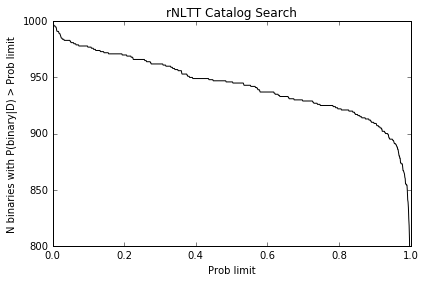

In [421]:
#print len(np.where(prob_out['P_posterior']>0.5)[0])
#print len(np.where(prob_out['P_posterior']>0.2)[0])

x_ran = np.linspace(0.0001, 1.0, 1000)
y = np.zeros(len(x_ran))
for i in np.arange(len(x_ran)):
    
    y[i] = len(np.where(prob_out['P_posterior']>x_ran[i])[0])
    
plt.plot(x_ran, y, color='k')

plt.ylim(800,1000)

plt.title('rNLTT Catalog Search')
plt.xlabel('Prob limit')
plt.ylabel('N binaries with P(binary|D) > Prob limit')

plt.tight_layout()
plt.savefig('../figures/rNLTT_P_posterior.pdf')
#plt.show()

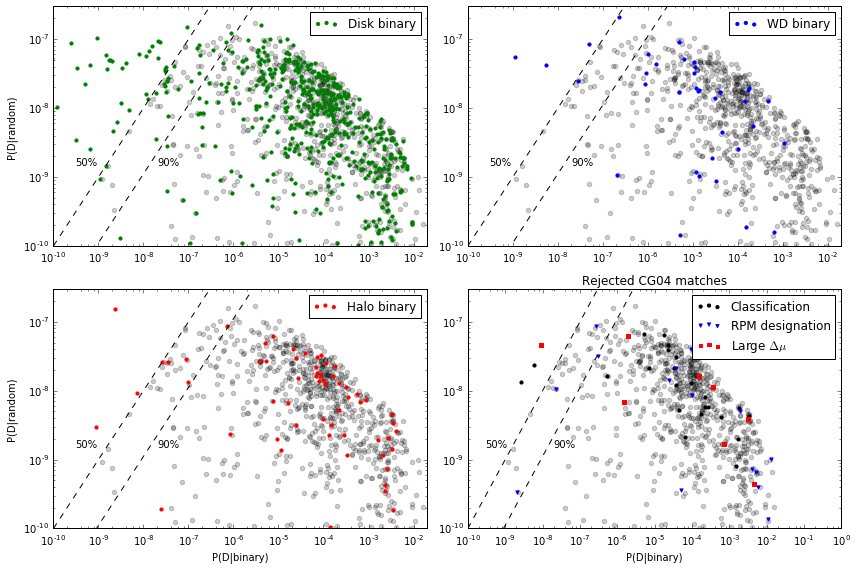

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

id_good = np.where(prob_out['P_posterior']>0.5)


# Plot entire NLTT catalog
p_limit = 0.9
x_tmp = np.linspace(1.0e-10, 2.0e-2, 100)
y_tmp = (1.0/p_limit) * (1.0-p_limit)*x_tmp
ax[0,0].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[0,0].text(2.0e-8, 1.5e-9, '90%')
ax[0,1].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[0,1].text(2.0e-8, 1.5e-9, '90%')
ax[1,0].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[1,0].text(2.0e-8, 1.5e-9, '90%')
ax[1,1].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[1,1].text(2.0e-8, 1.5e-9, '90%')
p_limit = 0.5
x_tmp = np.linspace(1.0e-10, 2.0e-2, 100)
y_tmp = (1.0/p_limit) * (1.0-p_limit)*x_tmp
ax[0,0].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[0,0].text(3.0e-10, 1.5e-9, '50%')
ax[0,1].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[0,1].text(3.0e-10, 1.5e-9, '50%')
ax[1,0].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[1,0].text(3.0e-10, 1.5e-9, '50%')
ax[1,1].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[1,1].text(3.0e-10, 1.5e-9, '50%')


ax[0,0].scatter(prob_out['P_binary'][id_good], prob_out['P_random'][id_good], color='k', alpha=0.2)
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 1)
ax[0,0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='g', label='Disk binary', s=10)

ax[0,0].set_xlim(1.0e-10, 2.0e-2)
ax[0,0].set_ylim(1.0e-10, 3.0e-7)
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('P(D|random)')
ax[0,0].legend(loc=1)



# Plot entire NLTT catalog
ax[1,0].scatter(prob_out['P_binary'][id_good], prob_out['P_random'][id_good], color='k', alpha=0.2)
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 2)
ax[1,0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='r', label='Halo binary', s=10)

ax[1,0].set_xlim(1.0e-10, 2.0e-2)
ax[1,0].set_ylim(1.0e-10, 3.0e-7)
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('P(D|binary)')
ax[1,0].set_ylabel('P(D|random)')
ax[1,0].legend(loc=1)





# Plot entire NLTT catalog
ax[0,1].scatter(prob_out['P_binary'][id_good], prob_out['P_random'][id_good], color='k', alpha=0.2)
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 3)
ax[0,1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='b', label='WD binary', s=10)

ax[0,1].set_xlim(1.0e-10, 2.0e-2)
ax[0,1].set_ylim(1.0e-10, 3.0e-7)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].legend(loc=1)


# Plot entire NLTT catalog
ax[1,1].scatter(prob_out['P_binary'][id_good], prob_out['P_random'][id_good], color='k', alpha=0.2)
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 4)
ax[1,1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='k', label='Classification', s=10, marker='o')
ids = np.where(prob_out_CG['CCode'] == 5)
ax[1,1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='b', label='RPM designation', s=10, marker='v')
ids = np.where(prob_out_CG['CCode'] == 6)
ax[1,1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='r', label=r'Large $\Delta \mu$', s=10, marker="s")
# ids = np.where(prob_out_CG['CCode'] == 7)
# ax[1,1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='g', label='Missing star', s=10, marker='*')

ax[1,1].set_xlim(1.0e-10, 1.0)
ax[1,1].set_ylim(1.0e-10, 3.0e-7)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('P(D|binary)')
ax[1,1].set_title('Rejected CG04 matches')
ax[1,1].legend(loc=1)

plt.tight_layout()
plt.savefig('../figures/rNLTT_P_binary_P_random.pdf')
#plt.show()

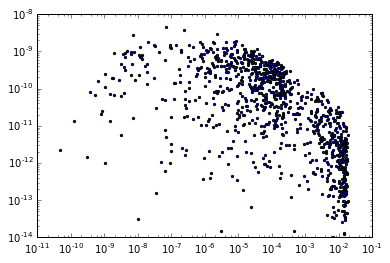

In [23]:
plt.scatter(prob_out['P_binary'], prob_out['P_random'], marker='.')

plt.xlim(1.0e-11, 1.0e-1)
plt.ylim(1.0e-14, 1.0e-8)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [24]:
match = 0

for i in np.arange(len(prob_out_CG)):
    ids = np.where(prob_out['NLTT_1'] == prob_out_CG['NLTT_1'][i])

    if prob_out['NLTT_2'][ids][0] == prob_out_CG['NLTT_2'][i]: 
        match = match + 1
    else:
#         print prob_out['NLTT_1'][ids][0], prob_out['NLTT_2'][ids][0], \
#                 prob_out_CG['NLTT_2'][i], prob_out_CG['P_binary'][i], \
#                 prob_out_CG['P_random'][i]
        
        id1 = np.where(t['NLTT'] == prob_out_CG['NLTT_1'][i])
        id2 = np.where(t['NLTT'] == prob_out_CG['NLTT_2'][i])
        
        
#        id1 = prob_out_CG['NLTT_1'][i]
#        id2 = prob_out_CG['NLTT_2'][i]
        ra1, dec1 = t['ra'][id1][0], t['dec'][id1][0]
        mu_ra1, mu_dec1 = t['mu_ra'][id1][0], t['mu_dec'][id1][0]
        mu_ra_err1, mu_dec_err1 = t['mu_ra_err'][id1][0], t['mu_dec_err'][id1][0]
        ra2, dec2 = t['ra'][id2][0], t['dec'][id2][0]
        mu_ra2, mu_dec2 = t['mu_ra'][id2][0], t['mu_dec'][id2][0]
        mu_ra_err2, mu_dec_err2 = t['mu_ra_err'][id2][0], t['mu_dec_err'][id2][0]
        
        print prob_out_CG['CCode'][i]
        print id1[0], ra1, dec1, mu_ra1, mu_dec1, mu_ra_err1, mu_dec_err1
        print id2[0], ra2, dec2, mu_ra2, mu_dec2, mu_ra_err2, mu_dec_err2
        
print match

ValueError: no field of name NLTT_1

### Generate the RPM diagram

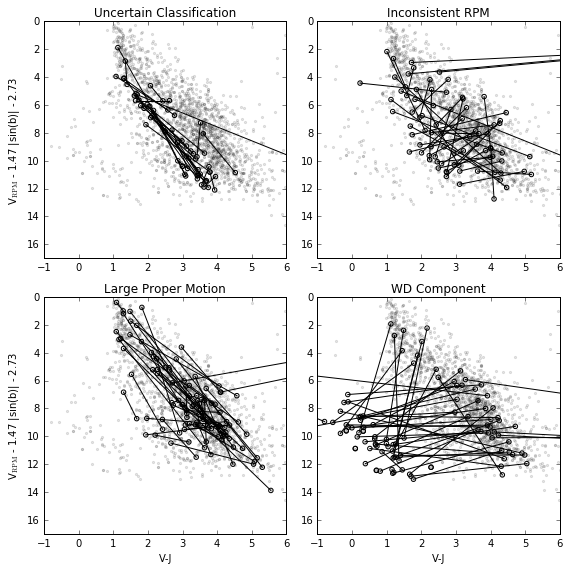

In [51]:
fig, ax = plt.subplots(2,2, figsize=(8,8))

for i in np.arange(len(prob_out_CG)):
        
    ids = np.where(prob_out['NLTT_1'] == prob_out_CG['NLTT_1'][i])

    if prob_out['NLTT_2'][ids][0] == prob_out_CG['NLTT_2'][i]: 
        match = match + 1

        # IDs
        id1 = np.where(t['NLTT'] == prob_out_CG['NLTT_1'][i])
        id2 = np.where(t['NLTT'] == prob_out_CG['NLTT_2'][i])

        # Positions (degrees)
        ra_1, dec_1 = t['ra'][id1][0], t['dec'][id1][0]
        ra_2, dec_2 = t['ra'][id2][0], t['dec'][id2][0]
        # Positions (Galactic)
        c_1 = SkyCoord(ra=ra_1*u.degree, dec=dec_1*u.degree, frame='icrs')
        c_2 = SkyCoord(ra=ra_2*u.degree, dec=dec_2*u.degree, frame='icrs')
        b_1 = c_1.galactic.b.radian
        b_2 = c_2.galactic.b.radian
                
        # Proper motions
        mu_ra1, mu_dec1 = t['mu_ra'][id1][0], t['mu_dec'][id1][0]
        mu_ra2, mu_dec2 = t['mu_ra'][id2][0], t['mu_dec'][id2][0]
        mu_1 = np.sqrt(mu_ra1**2 + mu_dec1**2) / 1.0e3 # in asec/yr
        mu_2 = np.sqrt(mu_ra2**2 + mu_dec2**2) / 1.0e3 # in asec/yr
        
        # Reduced proper motion
        H_rpm_1 = t['V'][id1][0] + 5.0 * np.log10(mu_1) + 5.0
        H_rpm_2 = t['V'][id2][0] + 5.0 * np.log10(mu_2) + 5.0
        
        # Eta proper motion (For comparison with Chaname & Gould 2004)
        eta_rpm_1 = t['V'][id1][0] + 5.0 * np.log10(mu_1) - 1.47 * np.abs(np.sin(b_1)) - 2.73
        eta_rpm_2 = t['V'][id2][0] + 5.0 * np.log10(mu_2) - 1.47 * np.abs(np.sin(b_2)) - 2.73
        
        # Colors
        VJ_1 = t['V'][id1][0] - t['J'][id1][0]
        VJ_2 = t['V'][id2][0] - t['J'][id2][0]
        
        # Plot all matches
        ax[0,0].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
        ax[0,0].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)
        ax[1,0].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
        ax[1,0].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)
        ax[0,1].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
        ax[0,1].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)
        ax[1,1].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
        ax[1,1].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)

        # Plot rejections
        if prob_out_CG['CCode'][i] == 4:
            ax[0,0].plot([VJ_1, VJ_2], [eta_rpm_1, eta_rpm_2], color='k')
            ax[0,0].scatter(VJ_1, eta_rpm_1, marker='o', facecolors='none', edgecolors='k')
            ax[0,0].scatter(VJ_2, eta_rpm_2, marker='o', facecolors='none', edgecolors='k')
        if prob_out_CG['CCode'][i] == 5:
            ax[0,1].plot([VJ_1, VJ_2], [eta_rpm_1, eta_rpm_2], color='k')
            ax[0,1].scatter(VJ_1, eta_rpm_1, marker='o', facecolors='none', edgecolors='k')
            ax[0,1].scatter(VJ_2, eta_rpm_2, marker='o', facecolors='none', edgecolors='k')
        if prob_out_CG['CCode'][i] == 6:
            ax[1,0].plot([VJ_1, VJ_2], [eta_rpm_1, eta_rpm_2], color='k')
            ax[1,0].scatter(VJ_1, eta_rpm_1, marker='o', facecolors='none', edgecolors='k')
            ax[1,0].scatter(VJ_2, eta_rpm_2, marker='o', facecolors='none', edgecolors='k')
        if prob_out_CG['CCode'][i] == 3:
            ax[1,1].plot([VJ_1, VJ_2], [eta_rpm_1, eta_rpm_2], color='k')
            ax[1,1].scatter(VJ_1, eta_rpm_1, marker='o', facecolors='none', edgecolors='k')
            ax[1,1].scatter(VJ_2, eta_rpm_2, marker='o', facecolors='none', edgecolors='k')

    else:
        
        id1 = np.where(t['NLTT'] == prob_out_CG['NLTT_1'][i])
        id2 = np.where(t['NLTT'] == prob_out_CG['NLTT_2'][i])


ax[0,0].set_xlim(-1.0, 6.0)
ax[0,0].set_ylim(17.0, 0.0)
ax[1,0].set_xlim(-1.0, 6.0)
ax[1,0].set_ylim(17.0, 0.0)
ax[0,1].set_xlim(-1.0, 6.0)
ax[0,1].set_ylim(17.0, 0.0)
ax[1,1].set_xlim(-1.0, 6.0)
ax[1,1].set_ylim(17.0, 0.0)

ax[0,0].set_title('Uncertain Classification')
ax[0,1].set_title('Inconsistent RPM')
ax[1,0].set_title('Large Proper Motion')
ax[1,1].set_title('WD Component')

ax[1,0].set_xlabel('V-J')
ax[1,1].set_xlabel('V-J')
ax[0,0].set_ylabel(r'V$_{\rm RPM}$ - 1.47 |sin(b)| - 2.73')
ax[1,0].set_ylabel(r'V$_{\rm RPM}$ - 1.47 |sin(b)| - 2.73')

plt.tight_layout()

plt.savefig('../figures/rNLTT_RPM.pdf')
#plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:130: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


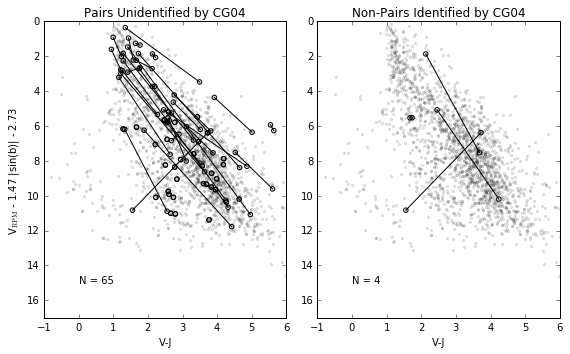

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))


nonmatch = 0
for i in np.arange(len(prob_out_CG)):
            
    ids = np.where(prob_out['NLTT_1'] == prob_out_CG['NLTT_1'][i])
    
#     if i == 100: break
    
    if prob_out['NLTT_2'][ids][0] == prob_out_CG['NLTT_2'][i]: 
        match = match + 1
        
        # IDs
        id1 = np.where(t['NLTT'] == prob_out_CG['NLTT_1'][i])
        id2 = np.where(t['NLTT'] == prob_out_CG['NLTT_2'][i])

        # Remove objects with no J or V photometry
        if t['J'][id1][0] < 1.0 or t['J'][id2][0] < 1.0: continue
        if t['V'][id1][0] < 1.0 or t['V'][id2][0] < 1.0: continue

        # Positions (degrees)
        ra_1, dec_1 = t['ra'][id1][0], t['dec'][id1][0]
        ra_2, dec_2 = t['ra'][id2][0], t['dec'][id2][0]
        # Positions (Galactic)
        c_1 = SkyCoord(ra=ra_1*u.degree, dec=dec_1*u.degree, frame='icrs')
        c_2 = SkyCoord(ra=ra_2*u.degree, dec=dec_2*u.degree, frame='icrs')
        b_1 = c_1.galactic.b.radian
        b_2 = c_2.galactic.b.radian
                
        # Proper motions
        mu_ra1, mu_dec1 = t['mu_ra'][id1][0], t['mu_dec'][id1][0]
        mu_ra2, mu_dec2 = t['mu_ra'][id2][0], t['mu_dec'][id2][0]
        mu_1 = np.sqrt(mu_ra1**2 + mu_dec1**2) / 1.0e3 # in asec/yr
        mu_2 = np.sqrt(mu_ra2**2 + mu_dec2**2) / 1.0e3 # in asec/yr
        
        # Reduced proper motion
        H_rpm_1 = t['V'][id1][0] + 5.0 * np.log10(mu_1) + 5.0
        H_rpm_2 = t['V'][id2][0] + 5.0 * np.log10(mu_2) + 5.0
        
        # Eta proper motion (For comparison with Chaname & Gould 2004)
        eta_rpm_1 = t['V'][id1][0] + 5.0 * np.log10(mu_1) - 1.47 * np.abs(np.sin(b_1)) - 2.73
        eta_rpm_2 = t['V'][id2][0] + 5.0 * np.log10(mu_2) - 1.47 * np.abs(np.sin(b_2)) - 2.73
        
        # Colors
        VJ_1 = t['V'][id1][0] - t['J'][id1][0]
        VJ_2 = t['V'][id2][0] - t['J'][id2][0]
        
        # Plot all matches
        ax[0].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
        ax[0].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)
        ax[1].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
        ax[1].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)

    else:
        # IDs
        id1 = np.where(t['NLTT'] == prob_out_CG['NLTT_1'][i])
        id2 = np.where(t['NLTT'] == prob_out_CG['NLTT_2'][i])

        # Remove objects with no J or V photometry
        if t['J'][id1][0] < 1.0 or t['J'][id2][0] < 1.0: continue
        if t['V'][id1][0] < 1.0 or t['V'][id2][0] < 1.0: continue

        # Positions (degrees)
        ra_1, dec_1 = t['ra'][id1][0], t['dec'][id1][0]
        ra_2, dec_2 = t['ra'][id2][0], t['dec'][id2][0]
        # Positions (Galactic)
        c_1 = SkyCoord(ra=ra_1*u.degree, dec=dec_1*u.degree, frame='icrs')
        c_2 = SkyCoord(ra=ra_2*u.degree, dec=dec_2*u.degree, frame='icrs')
        b_1 = c_1.galactic.b.radian
        b_2 = c_2.galactic.b.radian
                
        # Proper motions
        mu_ra1, mu_dec1 = t['mu_ra'][id1][0], t['mu_dec'][id1][0]
        mu_ra2, mu_dec2 = t['mu_ra'][id2][0], t['mu_dec'][id2][0]
        mu_1 = np.sqrt(mu_ra1**2 + mu_dec1**2) / 1.0e3 # in asec/yr
        mu_2 = np.sqrt(mu_ra2**2 + mu_dec2**2) / 1.0e3 # in asec/yr
        
        # Reduced proper motion
        H_rpm_1 = t['V'][id1][0] + 5.0 * np.log10(mu_1) + 5.0
        H_rpm_2 = t['V'][id2][0] + 5.0 * np.log10(mu_2) + 5.0
        
        # Eta proper motion (For comparison with Chaname & Gould 2004)
        eta_rpm_1 = t['V'][id1][0] + 5.0 * np.log10(mu_1) - 1.47 * np.abs(np.sin(b_1)) - 2.73
        eta_rpm_2 = t['V'][id2][0] + 5.0 * np.log10(mu_2) - 1.47 * np.abs(np.sin(b_2)) - 2.73
        
        # Colors
        VJ_1 = t['V'][id1][0] - t['J'][id1][0]
        VJ_2 = t['V'][id2][0] - t['J'][id2][0]
        
        # Plot all matches
        ax[0].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
        ax[0].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)
        ax[1].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
        ax[1].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)

        ax[1].plot([VJ_1, VJ_2], [eta_rpm_1, eta_rpm_2], color='k')
        ax[1].scatter(VJ_1, eta_rpm_1, marker='o', facecolors='none', edgecolors='k')
        ax[1].scatter(VJ_2, eta_rpm_2, marker='o', facecolors='none', edgecolors='k')

        nonmatch = nonmatch + 1




match = 0
#nonmatch = 0
nonmatch_found = 0

id_add = np.array([])
for i in np.arange(len(prob_out)):
        
    ids = np.where(prob_out['NLTT_1'][i] == prob_out_CG['NLTT_1'])
    if prob_out['NLTT_2'][i] == prob_out_CG['NLTT_2'][ids]:
        match = match + 1
    else:
    
#        nonmatch = nonmatch + 1
    
        if prob_out['P_posterior'][i] > 0.5:
            nonmatch_found = nonmatch_found + 1
            id_add = np.append(id_add, i)

    
counter = 0
# Create RPM diagram for identified pairs not in CG04 catalog
for ids in id_add:

    # IDs
    id1 = np.where(t['NLTT'] == prob_out['NLTT_1'][ids])
    id2 = np.where(t['NLTT'] == prob_out['NLTT_2'][ids])
    
    if t['J'][id1][0] < 1.0 or t['J'][id2][0] < 1.0: continue
    if t['V'][id1][0] < 1.0 or t['V'][id2][0] < 1.0: continue
    
    # Positions (degrees)
    ra_1, dec_1 = t['ra'][id1][0], t['dec'][id1][0]
    ra_2, dec_2 = t['ra'][id2][0], t['dec'][id2][0]
    # Positions (Galactic)
    c_1 = SkyCoord(ra=ra_1*u.degree, dec=dec_1*u.degree, frame='icrs')
    c_2 = SkyCoord(ra=ra_2*u.degree, dec=dec_2*u.degree, frame='icrs')
    b_1 = c_1.galactic.b.radian
    b_2 = c_2.galactic.b.radian
                
    # Proper motions
    mu_ra1, mu_dec1 = t['mu_ra'][id1][0], t['mu_dec'][id1][0]
    mu_ra2, mu_dec2 = t['mu_ra'][id2][0], t['mu_dec'][id2][0]
    mu_1 = np.sqrt(mu_ra1**2 + mu_dec1**2) / 1.0e3 # in asec/yr
    mu_2 = np.sqrt(mu_ra2**2 + mu_dec2**2) / 1.0e3 # in asec/yr
        
    # Reduced proper motion
    H_rpm_1 = t['V'][id1][0] + 5.0 * np.log10(mu_1) + 5.0
    H_rpm_2 = t['V'][id2][0] + 5.0 * np.log10(mu_2) + 5.0
        
    # Eta proper motion (For comparison with Chaname & Gould 2004)
    eta_rpm_1 = t['V'][id1][0] + 5.0 * np.log10(mu_1) - 1.47 * np.abs(np.sin(b_1)) - 2.73
    eta_rpm_2 = t['V'][id2][0] + 5.0 * np.log10(mu_2) - 1.47 * np.abs(np.sin(b_2)) - 2.73
        
    # Colors
    VJ_1 = t['V'][id1][0] - t['J'][id1][0]
    VJ_2 = t['V'][id2][0] - t['J'][id2][0]

    # Plot all matches
    ax[0].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
    ax[0].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)

    ax[0].plot([VJ_1, VJ_2], [eta_rpm_1, eta_rpm_2], color='k')
    ax[0].scatter(VJ_1, eta_rpm_1, marker='o', facecolors='none', edgecolors='k')
    ax[0].scatter(VJ_2, eta_rpm_2, marker='o', facecolors='none', edgecolors='k')

    
    counter = counter + 1
#     if np.abs(VJ_1-VJ_2)<0.1 and np.abs(eta_rpm_1-eta_rpm_2)<0.1: 
#         counter = counter
#     else:
#         counter = counter + 1
    
    
ax[0].set_xlim(-1.0, 6.0)
ax[0].set_ylim(17.0, 0.0)
ax[1].set_xlim(-1.0, 6.0)
ax[1].set_ylim(17.0, 0.0)

ax[0].set_title('Pairs Unidentified by CG04')
ax[1].set_title('Non-Pairs Identified by CG04')

ax[0].set_xlabel('V-J')
ax[1].set_xlabel('V-J')
ax[0].set_ylabel(r'V$_{\rm RPM}$ - 1.47 |sin(b)| - 2.73')

ax[0].text(0.0, 15.0, 'N = ' + str(counter))
ax[1].text(0.0, 15.0, 'N = ' + str(nonmatch))

plt.tight_layout()
plt.savefig('../figures/rNLTT_RPM_compare.pdf')
#plt.show()


In [53]:
ids = np.where(prob_out['P_posterior'] > 0.5)
print "Detected pairs with binary probabilities over 50%:", len(ids[0])
print "Chaname & Gould (2004) pairs:", len(prob_out_CG)
ids = np.intersect1d(np.where(prob_out_CG['P_posterior'] > 0.5), np.where(prob_out_CG['CCode'] < 4))
print "Chaname & Gould (2004) pairs with a probability over 50%:", len(prob_out_CG[ids])

match = 0
match_50 = 0
for i in np.arange(len(prob_out_CG)):
            
    ids = np.where(prob_out['NLTT_1'] == prob_out_CG['NLTT_1'][i])
    
    if prob_out['NLTT_2'][ids][0] == prob_out_CG['NLTT_2'][i]: 
        
        if prob_out_CG['CCode'][i] < 4:
            
            match = match + 1
            if prob_out_CG['P_posterior'][i] > 0.5:
                match_50 = match_50 + 1
            
print "Chaname & Gould (2004) pairs identified:", match
print "Chaname & Gould (2004) pairs with a probability over 50%:", match_50


Detected pairs with binary probabilities over 50%: 988
Chaname & Gould (2004) pairs: 1067
Chaname & Gould (2004) pairs with a probability over 50%: 744
Chaname & Gould (2004) pairs identified: 932
Chaname & Gould (2004) pairs with a probability over 50%: 743


### Let's figure out why we do not redetect some Chaname & Gould (2004) pairs

In [234]:
from functools import reduce

# All Chaname & Gould (2004) pairs
print "Total number of Chaname & Gould (2004) pairs:", len(CG_pairs)
print "Chaname & Gould (2004) pairs with CCode<4:", len(np.where(CG_pairs['CCode']<4)[0])
print ""

# Chaname & Gould (2004) pairs with entries in rNLTT catalog
print "Chaname & Gould (2004) pairs with corresponding entries in rNLTT catalog:", len(prob_out_CG)
N_out = 0
for i in np.arange(len(prob_out_CG)): 
    if np.any(prob_out_CG['NLTT_1'][i] == t['NLTT']): 
        N_out = N_out + 1
    else:
        if np.any(prob_out_CG['NLTT_2'][i] == t['NLTT']): 
            Nout = N_out + 1
print "Chaname & Gould (2004) pairs with entries in rNLTT catalog, good proper motions:", N_out
N_out = 0
N_unfound = 0
N_out_good = 0
for i in np.arange(len(prob_out_CG)): 
    
    if not np.any(prob_out_CG['NLTT_1'][i] == t['NLTT']) \
       or not np.any(prob_out_CG['NLTT_2'][i] == t['NLTT']):
        N_unfound = N_unfound + 1
    else:
        id1 = np.where(prob_out_CG['NLTT_1'][i] == t['NLTT'])[0]
        id2 = np.where(prob_out_CG['NLTT_2'][i] == t['NLTT'])[0]
        
        N_out = N_out + 1
        if prob_out_CG['P_posterior'][i] > 0.5: N_out_good = N_out_good + 1
print ""
print "We should expect to identify these pairs:"
print "Chaname & Gould (2004) pairs with entries in rNLTT catalog, good proper motions:", N_out
print "Chaname & Gould (2004) pairs with entries in rNLTT catalog, good proper motions, P_posterior > 50%:", N_out_good
print ""

# Chaname & Gould (2004) pairs with rNLTT, CCode<4, P_posterior>50%
ids = np.intersect1d(np.where(prob_out_CG['CCode']<4)[0], \
                     np.where(prob_out_CG['P_posterior']>0.5)[0])
print "Chaname & Gould (2004) pairs with rNLTT, with CCode<4 and P_posterior>50%:", len(ids)
ids = np.intersect1d(np.where(prob_out_CG['CCode']<4)[0], \
                     np.where(prob_out_CG['P_posterior']<0.5)[0])
print "Chaname & Gould (2004) pairs with rNLTT, with CCode<4 and P_posterior<50%:", len(ids)
print ""

# Chaname & Gould (2004) pairs with rNLTT, CCode<4, why do they have P_posterior<50%
ids = np.intersect1d(np.where(prob_out_CG['CCode']<4)[0], \
                     np.where(prob_out_CG['P_posterior']==0.0)[0])
print "Chaname & Gould (2004) pairs with rNLTT, with CCode<4 and exactly P_posterior=0%:", len(ids)
ids = np.intersect1d(np.where(prob_out_CG['CCode']<4)[0], \
                     np.where(prob_out_CG['P_posterior']>0.0)[0])
ids2 = np.intersect1d(ids, np.where(prob_out_CG['P_posterior']<0.50)[0])
print "Chaname & Gould (2004) pairs with rNLTT, with CCode<4 and 0<P_posterior=50%:", len(ids2)
ids = np.intersect1d(np.where(prob_out_CG['CCode']<4)[0], \
                     np.where(prob_out_CG['P_posterior']<0.0)[0])
print "Chaname & Gould (2004) pairs with rNLTT, with CCode<4 and P_posterior<0.0:", len(ids)
print ""


# 
print "Now, let's focus on pairs I found not in the Chaname & Gould (2004) detections"
ids = np.intersect1d(np.where(prob_out_CG['CCode']<4)[0], \
                     np.where(prob_out_CG['P_posterior']>0.5)[0])
print "I found", len(prob_out), "pairs, of which", \
        len(prob_out)-len(ids), "are not in the Chaname & Gould (2004) pairs"
ids = np.intersect1d(np.where(prob_out_CG['CCode']>=4)[0], \
                     np.where(prob_out_CG['P_posterior']>0.5)[0])
print "Pairs I detect, detected but rejected by Chaname & Gould (2004):", len(ids)
print ""





# A number of CG04 pairs have entries in the full rNLTT catalog without proper motion uncertainties
num_removed = 0
for i in np.arange(len(prob_out_CG)):
    n_ids = len(np.where(prob_out_CG['NLTT_1'][i] == t_full['NLTT'])[0])
    
    if not(np.any(prob_out_CG['NLTT_1'][i] == t['NLTT'])) \
       or not(np.any(prob_out_CG['NLTT_2'][i] == t['NLTT'])):
        if prob_out_CG['CCode'][i] < 4 and prob_out_CG['P_posterior'][i]>0.5:
            num_removed = num_removed + 1
#     ids = np.intersect1d(np.where(prob_out_CG['NLTT_1'][i] == t['NLTT'])[0], \
#                      np.where(prob_out_CG['NLTT_2'][i] == t['NLTT'])[0])
#     if len(ids) == 0: num_removed = num_removed + 1
        
print "Number removed:", num_removed


ids_CG_good = np.array([], dtype='i4')
ids_CG_low_prob = np.array([], dtype='i4')
ids_CG_catalog = np.array([], dtype='i4')
ids_CG_catalog_bad = np.array([], dtype='i4')
for i in np.arange(len(prob_out_CG)):
    id1 = np.where(prob_out_CG['NLTT_1'][i] == t['NLTT'])[0]
    id2 = np.where(prob_out_CG['NLTT_2'][i] == t['NLTT'])[0]
    
    if len(id1)<1 or len(id2)<1: 
        ids_CG_catalog_bad = np.append(ids_CG_catalog_bad, i)
        continue
    
    mu_err1 = np.sqrt(t['mu_ra_err'][id1]**2 + t['mu_dec_err'][id1]**2)
    mu_err2 = np.sqrt(t['mu_ra_err'][id2]**2 + t['mu_dec_err'][id2]**2)
    
    if mu_err1[0]>0.1 and mu_err2[0]>0.1:
        ids_CG_catalog = np.append(ids_CG_catalog, i)
        
        if prob_out_CG['P_posterior'][i]>0.5:
            ids_CG_good = np.append(ids_CG_good, i)
        else:
            ids_CG_low_prob = np.append(ids_CG_low_prob, i)
        
print "There are", len(CG_pairs), "pairs in the CG04 list."
print "There are a total of", len(prob_out_CG), "CG04 pairs with catalog entries."
print "Number of Chaname & Gould (2004) pairs with rNLTT entries with bad astrometry, and therefore removed with astrometry constraint:", len(ids_CG_catalog_bad)
print "That leaves", len(prob_out_CG)-len(ids_CG_catalog_bad), "possible pairs to find in our overall NLTT search"
print "Number of Chaname & Gould (2004) pairs with rNLTT entries with good astrometry, P>50%:", len(ids_CG_good)
print "Number of Chaname & Gould (2004) pairs with rNLTT entries with good astrometry, P<50%:", len(ids_CG_low_prob)
print ""

# print "Systems not found:"
# for i in ids_CG_good:
#     if not np.any(prob_out_CG['NLTT_1'][i] == prob_out['ID_1']):
#         print prob_out_CG['NLTT_1'][i], prob_out_CG['P_posterior'][i], prob_out_CG['P_binary'][i]

print "So there are 9 systems which have a >50% posterior probability when calculated once, but less than that when calculated by our main algorithm. These seem to mostly be marginal cases (low P_binary and low P_random), so I feel a bit comfortable ignoring these for the moment."
print ""

# print "Now, let's take a look at pairs that have low probabilities. Why?"
# for i in ids_CG_low_prob:
#     id1 = np.where(prob_out_CG['NLTT_1'][i] == t['NLTT'])[0]
#     id2 = np.where(prob_out_CG['NLTT_2'][i] == t['NLTT'])[0]

#     theta = P_random.get_theta_proj_degree(t['ra'][id1], t['dec'][id1], t['ra'][id2], t['dec'][id2])
#     delta_mu = np.sqrt((t['mu_ra'][id1]-t['mu_ra'][id2])**2 + (t['mu_dec'][id1]-t['mu_dec'][id2])**2)
#     print theta*3600.0, delta_mu
    


ids_different_match = np.array([])
ids_no_match = np.array([])
ids_no_match_prob = np.array([], dtype='i4')
ids_1_match = np.array([])
ids_2_match = np.array([])
for i in np.arange(len(prob_out)):

    ids1 = np.where(prob_out['ID_1'][i] == prob_out_CG['NLTT_1'][ids_CG_good])[0]
    n_ids1 = len(np.where(prob_out['ID_1'][i] == prob_out_CG['NLTT_1'][ids_CG_good])[0])
    
    if n_ids1 == 0:
        if np.any(prob_out['ID_2'][i] == prob_out_CG['NLTT_2'][ids_CG_good]):
            if len(np.where(prob_out['ID_2'][i] == prob_out_CG['NLTT_2'][ids_CG_good])[0])>1: print prob_out['ID_1'][i]
            ids_different_match = np.append(ids_different_match, prob_out['ID_1'][i])
            print prob_out['ID_1'][i], prob_out['ID_2'][i]
        else:
            ids_no_match = np.append(ids_no_match, prob_out['ID_1'][i])
            ids_no_match_prob = np.append(ids_no_match_prob, i)

    elif n_ids1 == 1:
        n_ids2 = len(np.where(prob_out['ID_2'][i] == prob_out_CG['NLTT_2'][ids_CG_good])[0])
        ids2 = np.where(prob_out['ID_2'][i] == prob_out_CG['NLTT_2'][ids_CG_good])[0]
        if np.any(prob_out['ID_2'][i] == prob_out_CG['NLTT_2'][ids_CG_good]):
            ids_1_match = np.append(ids_1_match, prob_out['ID_1'][i])
        else:
            print prob_out['ID_1'][i], prob_out['ID_2'][i]
            ids_different_match = np.append(ids_different_match, prob_out['ID_1'][i])

    else:
        print "HERE", n_ids1
#     if n_ids1 > 1:
#         ids_2_match = np.append(ids_2_match, prob_out['ID_1'][i])




print ""
print "Detected pairs:", len(ids_1_match)
print "Multiple matches:", len(ids_2_match)
print "Different matches:", len(ids_different_match)
print "New matches undetected by Chaname & Gould (2004):", len(ids_no_match)



#print prob_out['P_posterior'][ids_no_match_prob]
    
    
# plt.scatter(prob_out_CG['P_binary'][ids2], prob_out_CG['P_random'][ids2], color='k')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1.0e-100, 1.0e-1)
# plt.ylim(1.0e-13, 1.0e-7)

# plt.show()


Total number of Chaname & Gould (2004) pairs: 1147
Chaname & Gould (2004) pairs with CCode<4: 999

Chaname & Gould (2004) pairs with corresponding entries in rNLTT catalog: 1067
Chaname & Gould (2004) pairs with entries in rNLTT catalog, good proper motions: 976

We should expect to identify these pairs:
Chaname & Gould (2004) pairs with entries in rNLTT catalog, good proper motions: 883
Chaname & Gould (2004) pairs with entries in rNLTT catalog, good proper motions, P_posterior > 50%: 629

Chaname & Gould (2004) pairs with rNLTT, with CCode<4 and P_posterior>50%: 759
Chaname & Gould (2004) pairs with rNLTT, with CCode<4 and P_posterior<50%: 175

Chaname & Gould (2004) pairs with rNLTT, with CCode<4 and exactly P_posterior=0%: 82
Chaname & Gould (2004) pairs with rNLTT, with CCode<4 and 0<P_posterior=50%: 92
Chaname & Gould (2004) pairs with rNLTT, with CCode<4 and P_posterior<0.0: 1

Now, let's focus on pairs I found not in the Chaname & Gould (2004) detections
I found 1189 pairs, of 

3478/3481/3482 is a triple

8632/8633/8634 is a triple

29410/29413/29414 is a triple

47260/47261/47263 is a triple

There are 999 pairs with CCode 1, 2, or 3 in the Chaname & Gould (2004) catalog.

934 of these pairs had counterparts in the rNLTT catalog.

84 of these were not detected since their binary probability was 0.

137 of these have non-zero binary probabilities, but random alignment probabilities are more likely.

We find that, using our method 713 of these pairs, or about 75% are redetected.

In [55]:
counter = 0

for pair in CG_pairs:
    
    # Check if there is a match for star 1
    if len(np.where(pair['NLTT-A'] == t['NLTT'])[0]) == 0:
        if pair['CCode']<4: counter = counter + 1
#        print pair['NLTT-A']
        continue

    # Check if there is a match for star 2
    if len(np.where(pair['NLTT-B'] == t['NLTT'])[0]) == 0:
        if pair['CCode']<4: counter = counter + 1
#        print pair['NLTT-B']

print "Num skipped:", counter

Num skipped: 65


### Let's figure out why Chaname & Gould (2004) did not detect some of our pairs

In [98]:
prob_50 = prob_out[prob_out['P_posterior']>0.50]


ids_new = np.array([], dtype='i4')
ids_new_NLTT_A = np.array([], dtype='i4')
ids_new_NLTT_B = np.array([], dtype='i4')
NLTT_new = np.array([], dtype='i4')

match = 0
match_4 = 0
match_5 = 0
match_6 = 0
match_7 = 0
match_bad = 0
for i in np.arange(len(prob_50)):
            
    ids = np.where(prob_50['NLTT_1'][i] == prob_out_CG['NLTT_1'])

    if len(ids[0]) < 1: 
        ids_new = np.append(ids_new, i)
        NLTT_new = np.append(NLTT_new, prob_50['NLTT_1'][i])
        ids_new_NLTT_A = np.append(ids_new_NLTT_A, np.argmin(np.abs(prob_50['NLTT_1'][i] - t['NLTT'])))
        ids_new_NLTT_B = np.append(ids_new_NLTT_B, np.argmin(np.abs(prob_50['NLTT_2'][i] - t['NLTT'])))
        continue
        
    if prob_50['NLTT_2'][i] == prob_out_CG['NLTT_2'][ids][0]:
        if prob_out_CG['CCode'][ids][0] < 4: 
            match = match + 1
        elif prob_out_CG['CCode'][ids][0] == 4:
            match_4 = match_4 + 1
        elif prob_out_CG['CCode'][ids][0] == 5:
            match_5 = match_5 + 1
        elif prob_out_CG['CCode'][ids][0] == 6:
            match_6 = match_6 + 1
        elif prob_out_CG['CCode'][ids][0] == 7:
            match_7 = match_7 + 1
        else:
            match_bad = match_bad + 1
            
    else:
        print prob_50['NLTT_1'][i], prob_50['NLTT_2'][i], prob_out_CG['NLTT_2'][ids][0]
#         # IDs
#         id1 = np.where(t['NLTT'] == prob_out_CG['NLTT_1'][i])
#         id2 = np.where(t['NLTT'] == prob_out_CG['NLTT_2'][i])

print "Number of pairs with posterior probability >50\%:", len(prob_50)

print "Number of redetected CG04 pairs with CCode = 1, 2, or 3:", match
print "Number of redetected CG04 pairs with CCode = 4:", match_4
print "Number of redetected CG04 pairs with CCode = 5:", match_5
print "Number of redetected CG04 pairs with CCode = 6:", match_6
print "Number of redetected CG04 pairs with CCode = 7:", match_7
print "Number of redetected CG04 pairs with bad CCode:", match_bad

print len(ids_new)

20303 20304 20305
44415 44416 44446
47260 47261 47263
54464 54465 54478
Number of pairs with posterior probability >50\%: 988
Number of redetected CG04 pairs with CCode = 1, 2, or 3: 746
Number of redetected CG04 pairs with CCode = 4: 22
Number of redetected CG04 pairs with CCode = 5: 15
Number of redetected CG04 pairs with CCode = 6: 7
Number of redetected CG04 pairs with CCode = 7: 0
Number of redetected CG04 pairs with bad CCode: 0
194


I just checked:

20303/20304/20305 forms a potential triple system

44415/44416/44446 forms a potential triple system

47260/47261/47263 forms a potential triple system

54464/54465/54478 forms a potential triple system

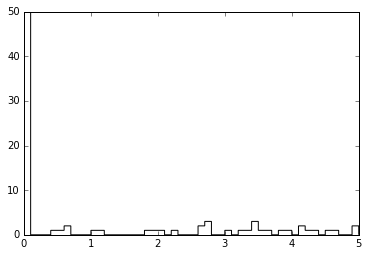

Number of binaries with theta < 1 arcsec: 50
58627 58628


In [123]:

# Proper motion histogram
# print "Number of binaries with exactly 1 mas/yr proper motion uncertainties (for at least 1 component):"
# print len(reduce(np.union1d, (np.where(t['mu_ra_err'][ids_new_NLTT_A] == 1.0)[0], \
#                          np.where(t['mu_dec_err'][ids_new_NLTT_A] == 1.0)[0], \
#                          np.where(t['mu_ra_err'][ids_new_NLTT_B] == 1.0)[0], \
#                          np.where(t['mu_dec_err'][ids_new_NLTT_B] == 1.0)[0])))



# Angular separation histogram
tmp_theta = np.sqrt((t['ra'][ids_new_NLTT_A]-t['ra'][ids_new_NLTT_B])**2 * np.cos(t['dec'][ids_new_NLTT_A]) \
            * np.cos(t['dec'][ids_new_NLTT_B]) + (t['dec'][ids_new_NLTT_A]-t['dec'][ids_new_NLTT_B])**2) * 3600.0
plt.hist(tmp_theta, histtype='step', color='k', bins=50, range=(0.0, 5.0))
plt.show()
print "Number of binaries with theta < 1 arcsec:", len(np.where(tmp_theta<0.2)[0])

print t['NLTT'][ids_new_NLTT_A[-1]], t['NLTT'][ids_new_NLTT_B[-1]]

# P_binary vs. P_random plot
# plt.scatter(prob_50['P_binary'][ids_new], prob_50['P_random'][ids_new], color='k')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1.0e-9, 1.0e-1)
# plt.ylim(1.0e-12, 1.0e-6)
# plt.show()

In [58]:
ids = np.where(prob_out_CG['CCode']<4)[0]

list_NLTT = np.array([])
for i in np.arange(len(ids)):
    if prob_out_CG['P_posterior'][i] > 0.45 and prob_out_CG['P_posterior'][i] < 0.55:
        print prob_out_CG['NLTT_1'][i], prob_out_CG['NLTT_2'][i], prob_out_CG['P_posterior'][i], \
            prob_out_CG['P_random'][i], prob_out_CG['P_binary'][i]
        list_NLTT = np.append(list_NLTT, prob_out_CG['NLTT_1'][i])



for i in np.arange(len(list_NLTT)):
    ids = np.where(list_NLTT[i] == prob_out['NLTT_1'])
    
    print i, ids[0], prob_out['NLTT_1'][ids], prob_out['NLTT_2'][ids], prob_out['P_posterior'][ids], \
        prob_out['P_random'][ids], prob_out['P_binary'][ids]


13673 13674 0.538416484637 1.66306661672e-08 1.93989267746e-08
21351 21352 0.499913595708 2.62194402422e-08 2.62103799192e-08
26559 26562 0.513844309059 2.12419461562e-07 2.24517646283e-07
26720 26721 0.458959258976 3.50789966774e-08 2.97571496931e-08
28469 28470 0.536288568163 2.46206396277e-08 2.847410408e-08
28632 28633 0.540292168605 9.33892432443e-10 1.09759880757e-09
35335 35336 0.542499736371 4.11047584919e-08 4.87416563841e-08
35937 35939 0.450747801639 3.68393538417e-08 3.02324830151e-08
40336 40337 0.483584476154 1.37071159579e-08 1.28356878986e-08
0 [8762] [13673] [13674] [ 0.98624614] [  1.63387396e-08] [  1.17160009e-06]
1 [13870] [21351] [21352] [ 0.51944697] [  2.58160876e-08] [  2.79055328e-08]
2 [17263] [26559] [26562] [ 0.44224133] [  2.28929469e-07] [  1.81515911e-07]
3 [17379] [26720] [26721] [ 0.98008013] [  3.36637634e-08] [  1.65629506e-06]
4 [18437] [28469] [28470] [ 0.97998111] [  2.46864934e-08] [  1.20847372e-06]
5 [18526] [28632] [28633] [ 0.56145271] [  9.2

In [59]:
j = 1

id1 = np.where(list_NLTT[j] == t['NLTT'])[0]
ids = np.where(list_NLTT[j] == prob_out['NLTT_1'])
id2 = np.where(prob_out['NLTT_2'][ids] == t['NLTT'])[0]

star1 = t['ra'][id1], t['dec'][id1], t['mu_ra'][id1], t['mu_dec'][id1], t['mu_ra_err'][id1], t['mu_dec_err'][id1]
star2 = t['ra'][id2], t['dec'][id2], t['mu_ra'][id2], t['mu_dec'][id2], t['mu_ra_err'][id2], t['mu_dec_err'][id2]    
theta = P_random.get_theta_proj_degree(star1[0], star1[1], star2[0], star2[1]) * 3600.0
delta_mu = np.sqrt((star1[2]-star2[2])**2 + (star1[3]-star2[3])**2)
delta_mu_ra_err = np.sqrt(star1[4]**2 + star2[4]**2)
delta_mu_dec_err = np.sqrt(star1[5]**2 + star2[5]**2)


colors=['b','r','g']
labels=[r'10$^5$',r'10$^6$',r'10$^7$']

num_binary = 10.**np.linspace(5., 7., 3)
for k in np.arange(len(num_binary)):
    P_binary.generate_binary_set(num_sys=num_binary[k])

    num = 100
    size = 10**np.linspace(2, 5, num)
    prob_binary = np.zeros(num)
    for i in np.arange(num):
        delta_mu_ra_sample = normal(loc=(star1[2]-star2[2]), scale=delta_mu_ra_err, size=size[i])
        delta_mu_dec_sample = normal(loc=(star1[3]-star2[3]), scale=delta_mu_dec_err, size=size[i])
        delta_mu_sample = np.sqrt(delta_mu_ra_sample**2 + delta_mu_dec_sample**2)
        prob_binary[i] = 1.0/size[i] * np.sum(P_binary.get_P_binary(theta, delta_mu_sample))

    plt.plot(size, prob_binary, color=colors[k], label=labels[k])


plt.title(r'Convergence test for number of $\Delta \mu$ samples')
plt.xscale('log')
plt.xlabel(r'Number of $\Delta \mu$ samples')
plt.ylabel('P(random)')
plt.legend()

plt.tight_layout()
#plt.savefig('../figures/convergence_mu.pdf')
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 